In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
import os, sys
from pathlib import Path

def find_src_folder():
    current = Path(os.getcwd()).resolve()
    for p in [current] + list(current.parents):
        src = p / "src"
        if src.exists():
            return src
    raise RuntimeError("src 폴더를 찾을 수 없습니다.")

src_path = find_src_folder()
sys.path.append(str(src_path))

In [6]:
# %%writefile dungeon_event_agent.py
from langchain.chat_models import init_chat_model
from enums.LLM import LLM
from agents.dungeon.dungeon_state import DungeonEventParser

llm = init_chat_model(model=LLM.GPT5_1, temperature=0.5)

from prompts.promptmanager import PromptManager
from prompts.prompt_type.dungeon.DungeonPromptType import DungeonPromptType
from agents.dungeon.dungeon_state import DungeonEventState
from db.RDBRepository import RDBRepository
from langchain_core.messages import HumanMessage


def heroine_memories_node(state: DungeonEventState) -> DungeonEventState:
    heroine_id = state["heroine_data"]["heroine_id"]
    memory_progress = state["heroine_data"]["memory_progress"]

    repo = RDBRepository()
    heroine_memories = repo.select_first_row(heroine_id, memory_progress)

    return {"heroine_memories": heroine_memories}


def selected_main_event_node(state: DungeonEventState) -> DungeonEventState:
    # 1. DB에서 main_event 목록을 가져와야댐
    # 2. DB에서 던전 정보를 꺼내야함
    # 3. 전층에서 중복 안되게끔만 난수로 메인 이벤트 생성
    return {"selected_main_event": "asd"}


def create_sub_event_node(state: DungeonEventState) -> DungeonEventState:
    prompts = PromptManager(DungeonPromptType.DUNGEON_SUB_EVENT).get_prompt(
        heroine_data=state["heroine_data"],
        heroine_memories=state["heroine_memories"],
        selected_main_event=state["selected_main_event"],
        event_room=state["event_room"],
        next_floor=state["next_floor"],
    )

    parser_llm = llm.with_structured_output(DungeonEventParser)
    response = parser_llm.invoke(prompts)
    final_answer = state["selected_main_event"] + "\n\n----------" + response.sibal
    print(response)
    return {
        "messages": [HumanMessage(response.sibal)],
        "sub_event": response.sibal,
        "final_answer": final_answer,
    }


from langgraph.graph import START, END, StateGraph


graph_builder = StateGraph(DungeonEventState)
graph_builder.add_node("heroine_memories_node", heroine_memories_node)
graph_builder.add_node("selected_main_event_node", selected_main_event_node)
graph_builder.add_node("create_sub_event_node", create_sub_event_node)

graph_builder.add_edge(START, "heroine_memories_node")
graph_builder.add_edge("heroine_memories_node", "selected_main_event_node")

graph_builder.add_edge("selected_main_event_node", "create_sub_event_node")
graph_builder.add_edge("create_sub_event_node", END)
graph_builder

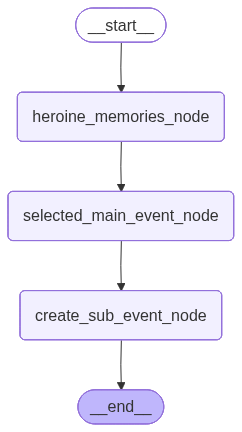

In [7]:
# from agents.dungeon.dungeon_event_agent import graph_builder
graph_builder.compile()

In [8]:
graph_builder.compile().invoke(
    {
        "heroine_data": {
            "heroine_id": 1,
            "memory_progress": 30,
        },
        "event_room" : 3,
        "next_floor" : 2
    }
)

sibal='질문이나 요청이 비어 있습니다. 세계관과 히로인/능력 관련 데이터의 형식을 제공하셨지만, 구체적으로 무엇을 도와야 할지(예: 시나리오 작성, 능력 설계, 이벤트 생성 등)가 명시되지 않았습니다.\n\n다음을 알려주시면 바로 이어서 작성하겠습니다.\n1) 이 데이터들을 기반으로 무엇을 만들고 싶은지\n   - 예: TRPG/게임용 이벤트, 비주얼노벨 시나리오, 소설 챕터, 캐릭터 카드, 능력 설명서 등\n2) {heroine_data}, {heroine_memories}, {selected_main_event}, {current_floor} 자리에 실제로 들어갈 예시 데이터가 있다면 그대로 붙여넣기\n3) 원하는 출력 형식\n   - 예: JSON, 대사 위주 스크립트, 묘사 위주 소설풍, 게임 로그 형식 등\n\n이 세 가지만 알려주시면, 레테/카다스 세계관에 맞춰 바로 구조화해서 이어서 만들어 드리겠습니다.'


{'messages': [HumanMessage(content='질문이나 요청이 비어 있습니다. 세계관과 히로인/능력 관련 데이터의 형식을 제공하셨지만, 구체적으로 무엇을 도와야 할지(예: 시나리오 작성, 능력 설계, 이벤트 생성 등)가 명시되지 않았습니다.\n\n다음을 알려주시면 바로 이어서 작성하겠습니다.\n1) 이 데이터들을 기반으로 무엇을 만들고 싶은지\n   - 예: TRPG/게임용 이벤트, 비주얼노벨 시나리오, 소설 챕터, 캐릭터 카드, 능력 설명서 등\n2) {heroine_data}, {heroine_memories}, {selected_main_event}, {current_floor} 자리에 실제로 들어갈 예시 데이터가 있다면 그대로 붙여넣기\n3) 원하는 출력 형식\n   - 예: JSON, 대사 위주 스크립트, 묘사 위주 소설풍, 게임 로그 형식 등\n\n이 세 가지만 알려주시면, 레테/카다스 세계관에 맞춰 바로 구조화해서 이어서 만들어 드리겠습니다.', additional_kwargs={}, response_metadata={}, id='77e4a1d1-7ec8-4b0e-a99e-f8905f964650')],
 'heroine_data': {'heroine_id': 1, 'memory_progress': 30},
 'heroine_memories': [1,
  1,
  10,
  '회상 1: 귀족의 어린 시절',
  '\n구분\n내용\n누가\n레티아 루크(당시 7세)가\n언제\n창세기 약 14년 전, 레티아가 어린 시절이었을 때\n어디서\n세일럼 왕국 수도 아캄의 루크 가문 저택에서\n무엇을\n귀족 가문의 장녀로서 검술, 학문, 예절 등 다방면의 교육을 받으며 성장했다\n어떻게\n매일 새벽부터 밤늦게까지 가문의 명예를 위한 혹독한 훈련을 받았으며, 실수가 허용되지 않는 환경에서 완벽함을 강요받았다\n왜\n루크 가문은 세일럼 왕국의 5대 귀족 가문 중 하나로, 가문의 후계자에게 흠잡을 데 없는 능력을 요구했기 때문이다\n\n[핵심 기억 요